In [5]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class queue:
    def __init__(self, env, arrival_rate, service_rate, num_servers):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.waiting_time_in_the_queue=[]
        

    def arrival(self):
        """The arrival process generates customers according to a Poisson process"""
        while True:
            ### Interarrival times follow exponential
            next_customer= random.expovariate(self.arrival_rate)
            ### Wait for the customer
            yield self.env.timeout(next_customer)  
            
            ### Start a service process
            self.env.process(self.service())

    def service(self):
        """The service process. The customer arrives and requests a service. The service time follows 
           the exponential distribution"""
        with self.server.request() as req:
            queue_arrival_time= self.env.now
            yield req
            #### calculate waiting time
            waiting_time = self.env.now - queue_arrival_time
            
            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)
            
            self.waiting_time_in_the_queue.append(waiting_time)

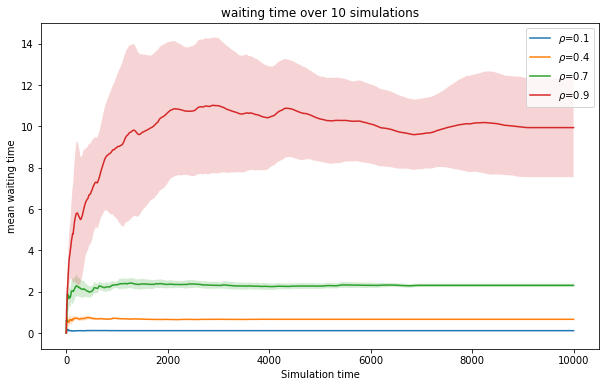

In [60]:
def setup_to_plot(arrival_rate, service_rate, sim_time, num_simulations, num_servers):
    """Setup, simulate and plot sample mean waiting time against the simulation time"""
    all_means_waiting_time= []
    
    for i in range(num_simulations):
        
        env = simpy.Environment()
        my_queue = queue(env, arrival_rate, service_rate, num_servers)
        env.process(my_queue.arrival())
        env.run(until=sim_time)
        
        means = []  # collect means for one silmulation over sim_time
        
        for i in range(1, sim_time + 1):
            subset_data=my_queue.waiting_time_in_the_queue[:i]
            mean = np.mean(subset_data)
            means.append(mean)            
            
        all_means_waiting_time.append(means)

    return np.mean(all_means_waiting_time, axis=0), np.std(all_means_waiting_time, axis=0)



simulation_time = 10000 
num_servers= 1
num_simulations = 10
service_rate =1   # keep service rate the same, but vary arrival rate to get range of rho values

plt.figure(figsize=(10, 6))

for arrival_rate in [0.1, 0.4, 0.7, 0.9]:
    means, st_devs= setup_to_plot(arrival_rate, service_rate, simulation_time, num_simulations,num_servers)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    plt.plot(range(1, simulation_time +1), means, label=r'$\rho$=' + f'{arrival_rate}')
    plt.fill_between(range(1, simulation_time +1), means+confid_int, means-confid_int, alpha=0.2)

plt.ylabel("mean waiting time")
plt.xlabel("Simulation time")
plt.legend()
plt.title("waiting time over 10 simulations")
#plt.savefig('.png', dpi=300)
plt.show()


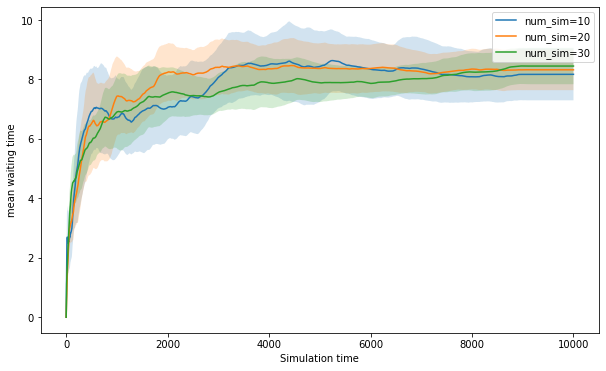

In [66]:
simulation_time = 10000 
num_servers= 1
service_rate =1
arrival_rate= 0.9  #so rho=0.9

plt.figure(figsize=(10, 6))

for num_simulations in [10, 20, 30]:
    means, st_devs= setup_to_plot(arrival_rate, service_rate, simulation_time, num_simulations,num_servers)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    plt.plot(range(1, simulation_time +1), means, label=r'num_sim=' + f'{num_simulations}')
    plt.fill_between(range(1, simulation_time +1), means+confid_int, means-confid_int, alpha=0.2)

plt.ylabel("mean waiting time")
plt.xlabel("Simulation time")
plt.legend()
plt.show()